In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot, lag_plot, scatter_matrix
import scipy as sp
import scipy.fftpack
import calendar
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from time import time

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

In [3]:
import json

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['axes.grid']=True

In [6]:
plt.rcParams["figure.figsize"] = (15,6)

In [7]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

# 1. Exploratory Data Analysis

Data was uploaded into a pandas dataframe. 

The information were long in time steps (datetimeIndex).


The recorded data had a start date of 1970-01-01 at 20:12:16 and end date of 1970-04-13 at 18:57:38.
There were total 93,142 *non-null* observations measured on 102 days (101 days, 22 hours, 45 minutes and 22 seconds to be exact).

The time stamps had frequency of more than one as clear from the data description table.

Data was not ordered as clear from the last five rows where the time stamps were not in *temporal order*.

In [8]:
# Upload data
data = pd.read_json('logins.json')
# Data Infrormation
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [9]:
# First five rows of data
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [10]:
# last 5 rows of data
data.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [11]:
# Data range and frequency description
data.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [12]:
datadesc = data.describe()
print('Length of oberservation period: {}'.format(datadesc.values[-1]-datadesc.values[-2]))

Length of oberservation period: [Timedelta('101 days 22:45:22')]


Initialize a counter vector for the logins (1 for each click) and set the *login_time* as the dataframe index.

This helps in **resampling** the information on differnent frequency levels such as hourly, daily, monthly, etc. and also support the fractions.

Data was resampled at 15 minutes and label was set to 'right' which gives the end of the interval.

In [13]:
data['login_counts'] = 1
data.set_index('login_time', inplace = True)
data.head()

,login_counts
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [14]:
data_15m = data.resample('15MIN', label = 'right').sum()
data_15m.head()

,login_counts
login_time,
1970-01-01 20:15:00,2
1970-01-01 20:30:00,6
1970-01-01 20:45:00,9
1970-01-01 21:00:00,7
1970-01-01 21:15:00,1


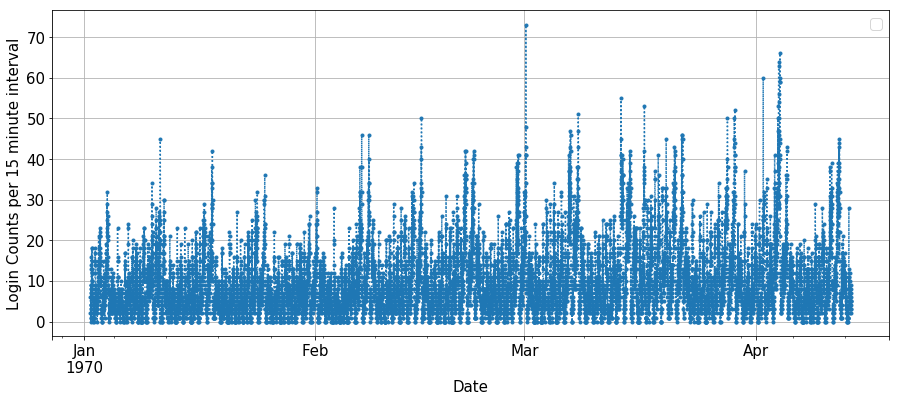

In [15]:
data_15m.plot(marker = '.',linestyle = ':');
plt.xlabel('Date')
plt.ylabel('Login Counts per 15 minute interval')
plt.legend([])

The time series did not provide much information as the time intervals were relatively small for visualization (plotting about 9800, 15-min time intervals. However, the time series plot does indicated maximum login count of somewhere around 75 in early march (start of the first week). The login count was also high in the first week of april. 
In order to extract more information the box plot and violin plots were plotted as shown below. The data had median value of 7. The data description table details the data statistics. The maximum count was 73 logins in 15 minute interval. The violin plot confirmed that the longin count was not uniformly distributed with value of 3 being most common number of logins in the 15 min intervals.

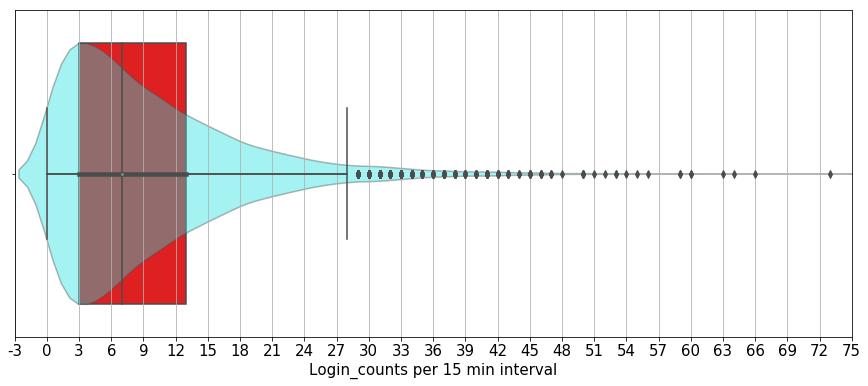

In [16]:
fig,ax1 = plt.subplots(1,1, sharex = True)

sns.violinplot(data_15m,color = 'cyan', alpha = 0.2, ax = ax1)
sns.boxplot(data_15m,color = 'red', ax = ax1)
ax1.set(xticks = np.arange(-3,78, 3),
       xticklabels=np.arange(-3,78,3),
       xlim = [-3,75],
       xlabel ='Login_counts per 15 min interval')
plt.setp(ax1.collections, alpha=.4) 

plt.subplots_adjust(hspace=0.01)
plt.show()

In [17]:
data_15m.describe().T

,count,mean,std,min,25%,50%,75%,max
login_counts,9788.0,9.515938,8.328818,0.0,3.0,7.0,13.0,73.0


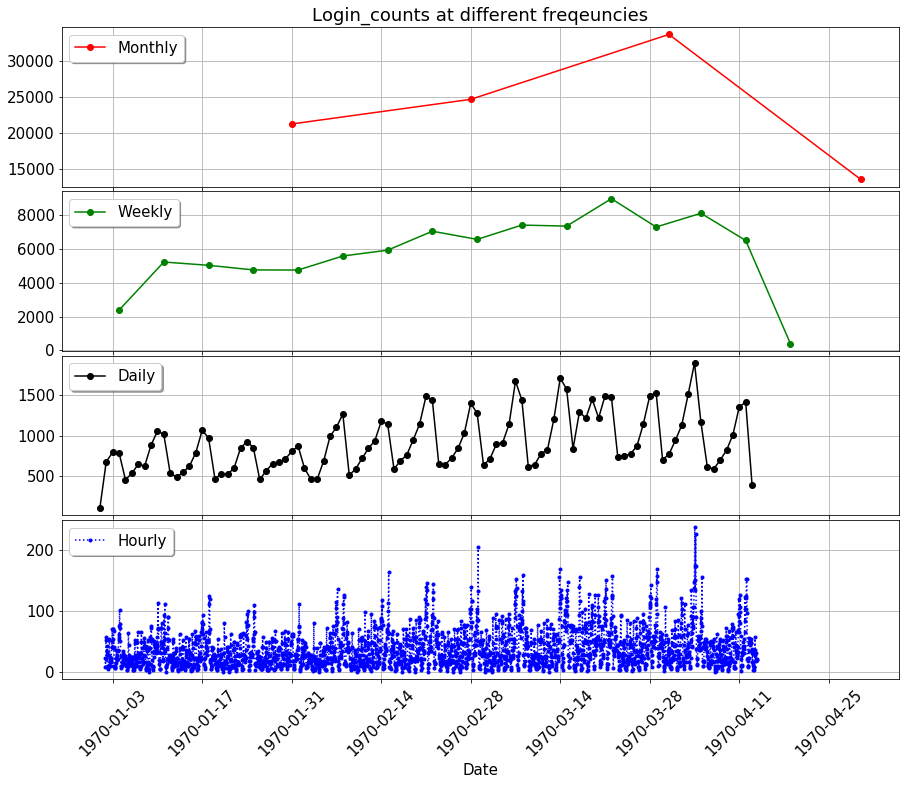

In [18]:
data_h = data.resample('H').sum() # Login counts each hour
data_d = data.resample('D').sum() # login counts each day
data_w = data.resample('W').sum() # login counts each week
data_m = data.resample('M').sum() # login count each month

fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize = (15,12),sharex = True)

ax1.plot(data_m, marker = 'o', color = 'r', label = 'Monthly')
ax1.legend(shadow=True, fancybox=True, loc = 'upper left')
ax1.set_title('Login_counts at different freqeuncies')
ax2.plot(data_w, marker = 'o', color = 'g', label = 'Weekly')
ax2.legend(shadow=True, fancybox=True, loc = 'upper left')
ax3.plot(data_d, marker = 'o', color = 'k', label = 'Daily')
ax3.legend(shadow=True, fancybox=True, loc = 'upper left')
ax4.plot(data_h, marker = '.', linestyle = ":",color = 'b', label = 'Hourly')
ax4.legend(shadow=True, fancybox=True, loc = 'upper left')

plt.xticks(rotation = '45')
ax4.set_xlabel('Date')
plt.subplots_adjust(hspace=0.03)

plt.show()

The montly plot suggested an increase in the login-counts each month (Jan-Feb-Mar). The data point for month of April is not reliable as the obeservations were only measured for the first. The increased number of logins was also supported by the weekly frequency plot. Again since the observations were not measured for the entire week, the last point of the frequency plot was not representative of the weekly login freqeuncy suggested by the previous weekly measurements. 

Daily freqeuncy plot was most informational among all the time series measured at different freqeuncies. It supported an increasing trend component of the logins and also suggested some seasonality in the data after about 6-7 daily observations, suggesting a seasonal pattern over the week. Hourly data plot had *informational congestion* due to too many points to explore.

Based on the information from the above plot, the weekly data points were explored as the next step. The average-histogram below shows the total number of login_counts measured per week day over the entire dataset.

In [19]:
data_d['login_day'] = data_d.index.weekday
data_d['login_month']= [calendar.month_name[i] for i in data_d.index.month]
data_d.head()

,login_counts,login_day,login_month
login_time,,,
1970-01-01,112,3,January
1970-01-02,681,4,January
1970-01-03,793,5,January
1970-01-04,788,6,January
1970-01-05,459,0,January


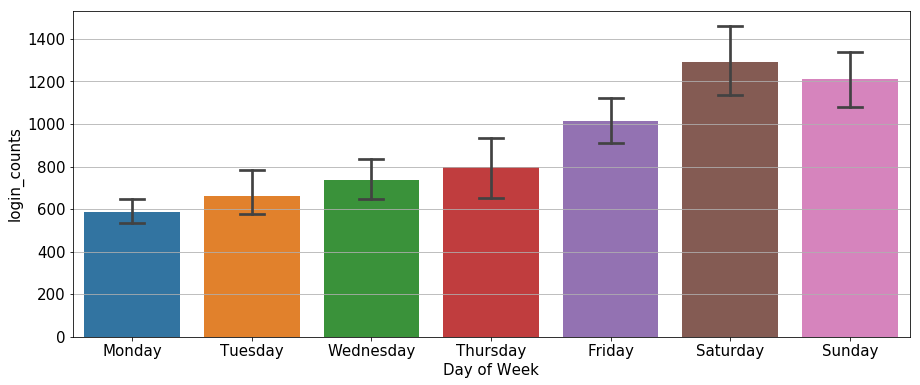

In [20]:
sns.barplot(x='login_day', y='login_counts', data=data_d, capsize = 0.2, orient = 'v')
plt.xticks(np.arange(0,7),list(calendar.day_name));
plt.xlabel('Day of Week')
plt.show()

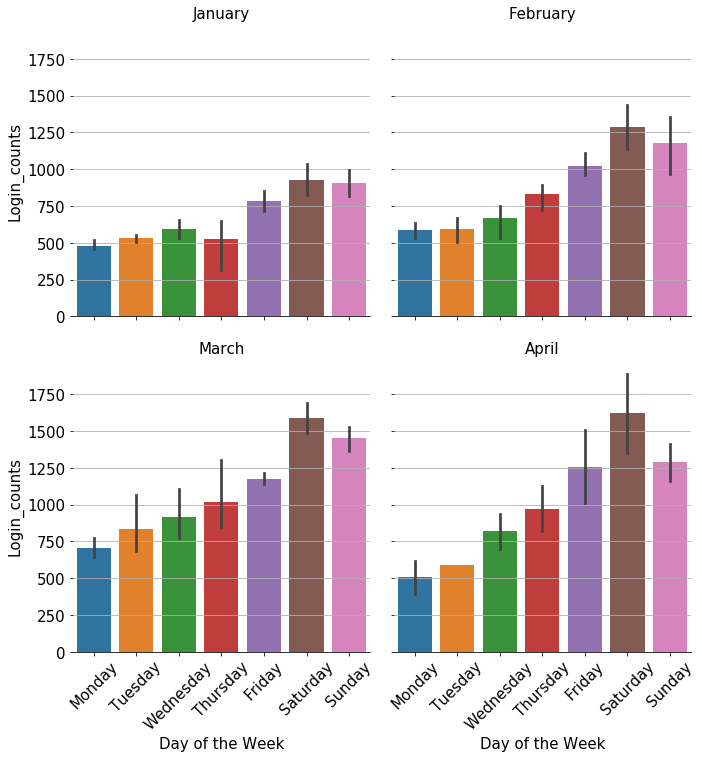

In [21]:
g = sns.catplot(x='login_day', y='login_counts',col = 'login_month',col_wrap =2, data=data_d, kind = 'bar')
(g.set_axis_labels("Day of the Week","Login_counts")
.set_xticklabels(list(calendar.day_name), rotation = '45')
.set_titles("{col_name}")
.despine(left=True))  ;

Based on the plots above it is clear that the login counts weree high over the weekend compared to rest of the weekdays with maximum numbers on a satruday. Based on the trend of the past three months, and given that the only half of the April counts were accounted for in the data, there is a high chance that login counts of April would match or exceed all previous three months. Table below shows the total login counts on each weekday per month.

The last observation was on Monday around 1900 hours.

In [22]:
data_m_wkd = pd.DataFrame(index = list(calendar.day_name))
for i in range(1,5):
    ind = '1970-0'+np.str(i)
    ind_name = calendar.month_name[i]
    if i == 1:
        data_m_wkd[ind_name] = data_d[ind].groupby('login_day').sum().values
    else:
        data_m_wkd[ind_name] = data_d[ind].groupby('login_day').sum().values
print(data_m_wkd)

           January  February  March  April
Monday        1926      2355   3532   1010
Tuesday       2124      2386   4168    590
Wednesday     2375      2670   3657   1637
Thursday      2640      3317   4058   1945
Friday        3907      4092   4696   2513
Saturday      4642      5149   6345   3241
Sunday        3625      4704   7267   2571


In [23]:
data_d['day_of_month'] = data_d.index.day
data_d.head()

,login_counts,login_day,login_month,day_of_month
login_time,,,,
1970-01-01,112,3,January,1
1970-01-02,681,4,January,2
1970-01-03,793,5,January,3
1970-01-04,788,6,January,4
1970-01-05,459,0,January,5


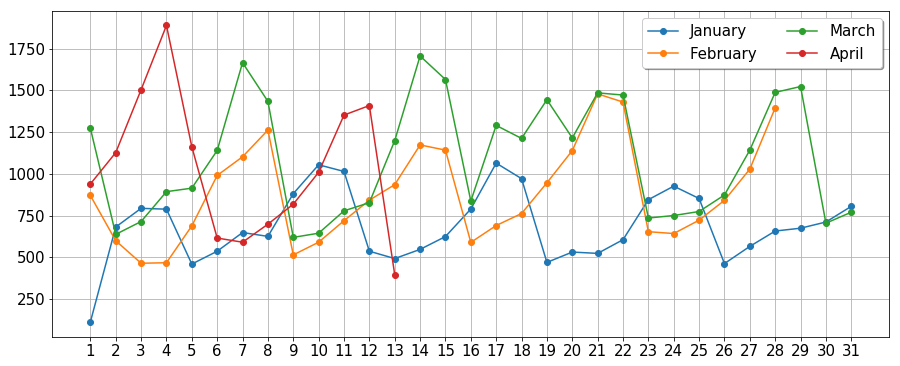

In [24]:
for i in range(1,5):
    plt.plot(data_d['1970-0'+np.str(i)].day_of_month,data_d['1970-0'+np.str(i)].login_counts, marker = 'o' )

plt.legend(data_d.login_month.unique(),
           loc = 'upper right', ncol=2, shadow=True, fancybox=True)
plt.xticks(np.arange(1,32))
plt.show()

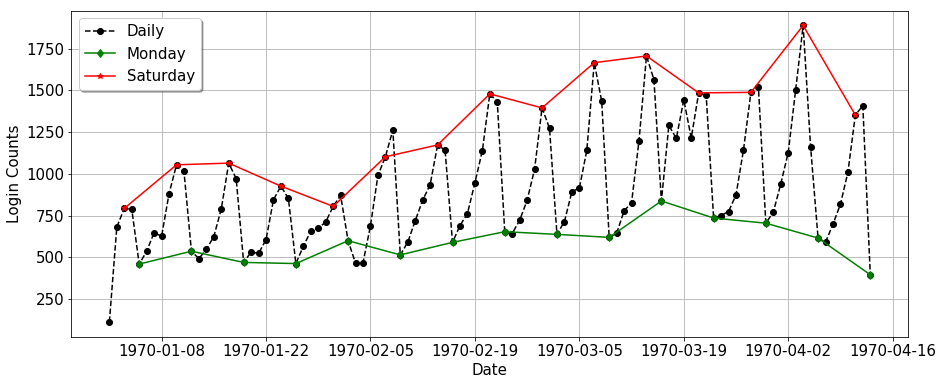

In [25]:
plt.plot(data_d.login_counts, 'ko--')
plt.plot(data_d[data_d.login_day==0].login_counts, 'gd-')
plt.plot(data_d[data_d.login_day==5].login_counts, 'r*-')


plt.legend(['Daily','Monday','Saturday'],loc = 'upper left', ncol=1, shadow=True, fancybox=True)
plt.xlabel('Date')
plt.ylabel('Login Counts')
plt.show()

The plot above shows that for each day of the month the trend was almosrt same. The trend of month of Feburary and March had high similarity. With similar variation along the week's day (Sunday, Monday, ...) this could be due to same starting day for both months (Feb 1, 1970 and March 1, 1970 fell in a sunday).

This could also explain the lag in the months of January and April which had the first day on a Thursday and Wedneasday respectively. The overall login counts were (almost) bound between the observations on Monday and Satruday.

In [26]:
data_h['login_hour'] = data_h.index.hour
data_h.head()

,login_counts,login_hour
login_time,,
1970-01-01 20:00:00,24,20
1970-01-01 21:00:00,9,21
1970-01-01 22:00:00,21,22
1970-01-01 23:00:00,58,23
1970-01-02 00:00:00,53,0


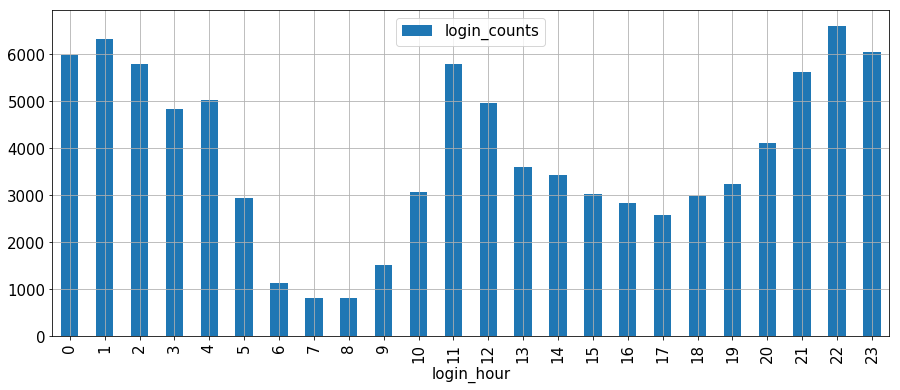

In [27]:
data_h.groupby('login_hour').sum().plot(kind = 'bar');

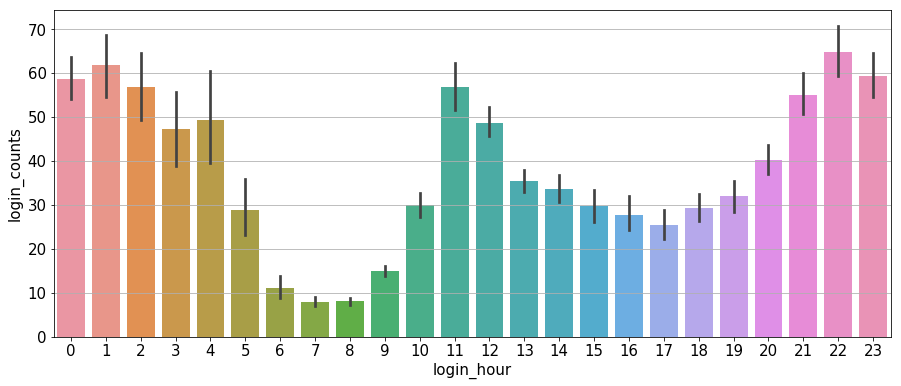

In [28]:
sns.barplot(data_h.login_hour,data_h.login_counts);

The above two plots shows the variation of login_counts along differnet hours during a day. The first plot shows the total count over the 3.5 months of observations and second histgram plot shows the daily averages. The login counts fluctuates during the 24 hour period with minimum around 7-8 am and maximum just prior to midnight. During the mid day and for most part of the night the hourly login_counts were higher than the averall-average.

In [29]:
data_h.describe().login_counts

count    2447.000000
mean       38.063752
std        30.752820
min         0.000000
25%        15.000000
50%        29.000000
75%        52.000000
max       237.000000
Name: login_counts, dtype: float64

## Summary

Due to consitent observations per time step, the data did not require any sort of forward or backward  sampling or *synthetic modifications* such as replacing null values which is rare in practice.

1. The login counts showed an upward trend from January to the month of March. Based on the more frequen results, there is a good chance that the trend would continue increasing unless faced with a major brekapoint event (war or natural calamity to name few **extremes**).

2. The weekly trend supported the monthly increament without any significant fluctuations indicating a healthy upward almost monotonic process (an average smoothed plot would be monotonic on existing plot).

3. On the day to day basis during a week, the login-count showed weekly seasonality with login counts increasing from the minimum on Monday to reaching the on saturday. After the weekend, the login counts had sharp fall.

4. On hourly basis, the trend was pretty consistent on any given day with login count falling (gradually) to minimum from midnight to morning hours between 7-8 AM. Then the login counts increased hitting the maximum *during the day* around mid day. The number fall back again near 4-5 PM but not as low as in the morning. Finally gradually increasing to maximum of 24 hours around midnight.




# 2. Experiment and Metrics Design

As per the problem statement the city operations division have proposed to reimburse drivers for the toll between the two cities in effort to encourage the drivers to be available for the both cities. The hypothesis is that providing toll reimbursement would increase the driver exchange between the two cities. 
Null hypothesis: There is no change is the trend and drivers are still exclusive
Alternate hypothesis: Adding toll does encourage drivers to cross the bridge

The most direct way to access is to monitor the toll reimbursements. Higher toll reimbusements would mean more drivers are taking advantage of the program. Following dataframe highlights the key metrics:

1. Direction of trip
2. Number of trip in each direction
3. Day and time of trip
4. Total number of tolls charged on the toll bridge in each direction

In relative terms if the number of toll reimbusements to drivers increased after the launch of program then the program is successfull. However the direction of trip also matter to track if there is any spatial skewness in the data i.e. one side is more active in using the benefit that the other side. 

In the nutshell, the overall trend much be monotonically non-decresing for the experiment to be successfull. 

# 3. Predictive Modeling

In [30]:
f = open('ultimate_data_challenge.json', 'r')
dfraw = pd.DataFrame(json.load(f))
f.close()
dfraw.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [31]:
dfraw.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [32]:
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Based on the information, drivers tend to rate the riders more than the reverse. Not all users have phone as their primary device. No other information is provided in this regards. First step in data exploration is to deal with the missing (null values). In this case, the best way to remove null is to replace it with the mean. Lets first check if there is any major variation in the ratings based on the city a user is from.

In [33]:
citygroup = dfraw.groupby('city').mean()
citygroup

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
city,,,,,,,,
Astapor,5.427940,4.798853,4.630593,1.086522,10.140305,1.948651,0.391738,60.370050
King's Landing,5.976596,4.853162,4.706997,1.070707,9.966979,2.463672,0.415202,63.232290
Winterfell,5.980153,4.730909,4.532996,1.068194,7.449927,2.431179,0.350146,60.318936


These individual values are not far from the overall average of 4.77815, 4.601559 (see dfraw.describe results). Just to be safe let us use the avergae per city to fill the respective null data.

In [34]:
citynames = dfraw.city.unique()
for c in citynames:
    nau_replace = dfraw.loc[dfraw.city == c,'avg_rating_by_driver'].mean()
    dfraw.loc[dfraw.city == c,'avg_rating_by_driver'] = dfraw.loc[dfraw.city == c,'avg_rating_by_driver'].fillna(nau_replace)
    
    nad_replace = dfraw.loc[dfraw.city == c,'avg_rating_of_driver'].mean()
    dfraw.loc[dfraw.city == c,'avg_rating_of_driver'] = dfraw.loc[dfraw.city == c,'avg_rating_of_driver'].fillna(nad_replace)

In [35]:
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Since no information regarding phone variable is provided lets replace the null values with 'UNKWN'.

In [36]:
dfraw['phone'].fillna('UNKNWN', inplace = True)

In [37]:
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


The final data set is free of all null values. The dataframe has total 12 columns:
    - 4 in object format
    - 6 in floating point format
    - 1 in integer format
    - 1 in boolean

Each feature is disucssed in the following sections. Before starting any data exploration, the dataset was copied into a new dataframe.

In [38]:
# Copy data into a new dataframe
df = dfraw

# 3.Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.


    1.Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
   
    2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

    3.Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

### Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYY MM DD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: the average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

## A. Categorical Data

In [39]:
def cat_plots(name):
    '''Input: Name of categorical variable
        Compute the mean values based on grouping under 'name'
        Plts the
    '''
    feature = {'avg_dist':'Avg Dist',
               "avg_rating_by_driver":'Usr Rating',
               "avg_rating_of_driver":'Drvr Rating',
               'avg_surge':'Avg Surge',
               'city':'City','surge_pct':'Surge %',
               'trips_in_first_30_days': '#First 30D Trips',
               'ultimate_black_user':'Black Users',
               'weekday_pct':'Weekday %'}
    data_desc = np.round(df.groupby(name).mean().T, 2)
    data_desc = data_desc.rename(index = feature)
    data_desc.reset_index(inplace = True)
    data_desc = data_desc.rename(columns={'index': name})
    data_desc.columns = [str(i).upper() for i in data_desc.columns]
    cell_text = []
    for row in range(len(data_desc)):
        cell_text.append(data_desc.iloc[row])
    
    count_df = df[name].value_counts()
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121)

    count_df.plot(kind = 'bar', width = 0.3)
    plt.xticks(rotation = '0')
    plt.title('Number of User')
    for i in range(len(count_df)):
        plt.text(i-0.1, count_df[i]+200, count_df[i])

    ###### Plot the data Frame #########
    ax = fig.add_subplot(122)
    t1 = plt.table(cellText=cell_text, colLabels=data_desc.columns,
                   loc='center',bbox = (0,0,1,1))
    ax.grid()
    t1.auto_set_font_size(False)
    t1.set_fontsize(15)
    plt.title('Mean Values')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.03)
    plt.show()

## Category - <span style="color:red">**CITY** </span>

======================================== GROUP BY CITY ========================================


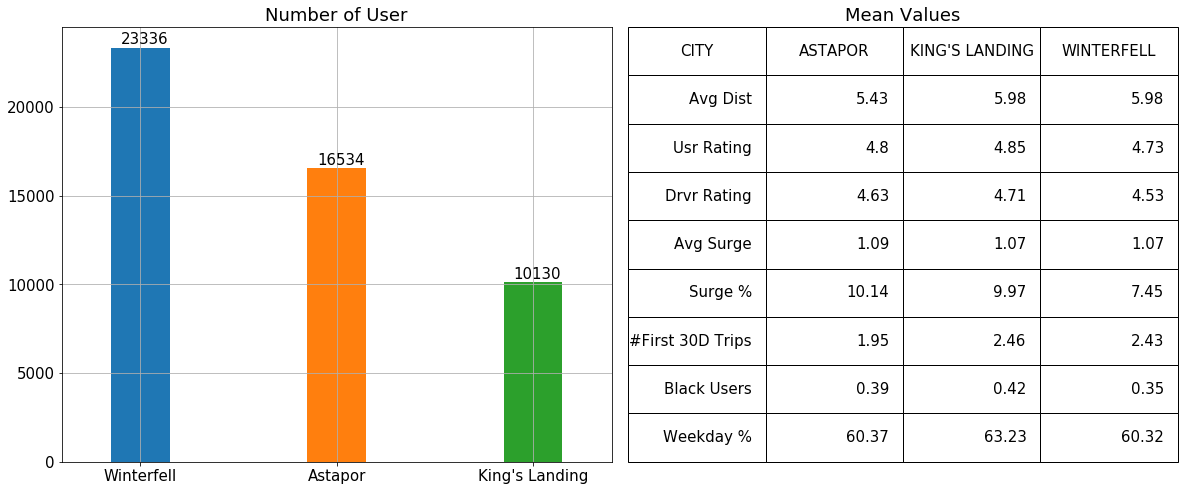

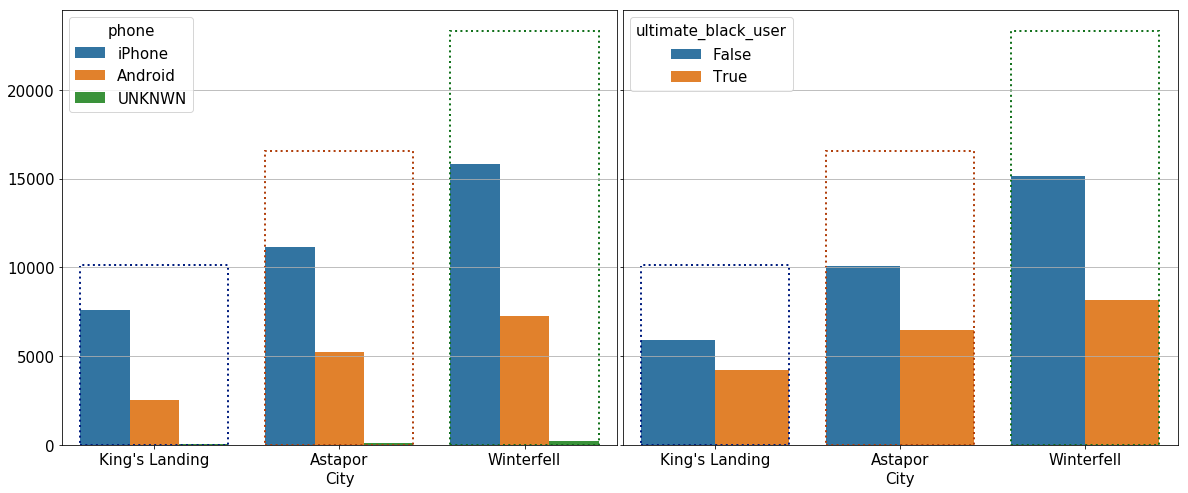

In [40]:
################################################################
print('=='*50)
print('=='*20,'GROUP BY CITY','=='*20)
print('=='*50)
citynames = df.city.unique()
cat_plots('city')
################################################################
fig,axes = plt.subplots(1,2,figsize=(20,8),sharey = True)
sns.countplot(x = 'city', hue = 'phone',data = df,linewidth=4, ax= axes[0])
sns.countplot(x = 'city',data = df, ax= axes[0],
              facecolor=(0, 0, 0, 0),
              linewidth=2,
              linestyle = ':',
              edgecolor=sns.color_palette("dark", 3))
axes[0].set_ylabel('')
axes[0].set_xlabel('City')
sns.countplot(x = 'city', hue = 'ultimate_black_user',data = df, ax= axes[1])
sns.countplot(x = 'city',data = df, ax= axes[1],
              facecolor=(0, 0, 0, 0),
              linewidth=2,
              linestyle = ':',
              edgecolor=sns.color_palette("dark", 3))
axes[1].set_ylabel('')
axes[1].set_xlabel('City')
plt.subplots_adjust(wspace=0.01)
plt.show()
################################################################

In all three cities, almost 99% of users had either an iphone or an android for connecting with the drivers. The number of iphone users were higher in all three cities. The ratio of iphone to androids was almost same for Astapor and Winterfell, and higher than King's Landing. The ratio trend was similar for the number of users with Ultimate black in each city. King's Landing had most number of ultimate black users.

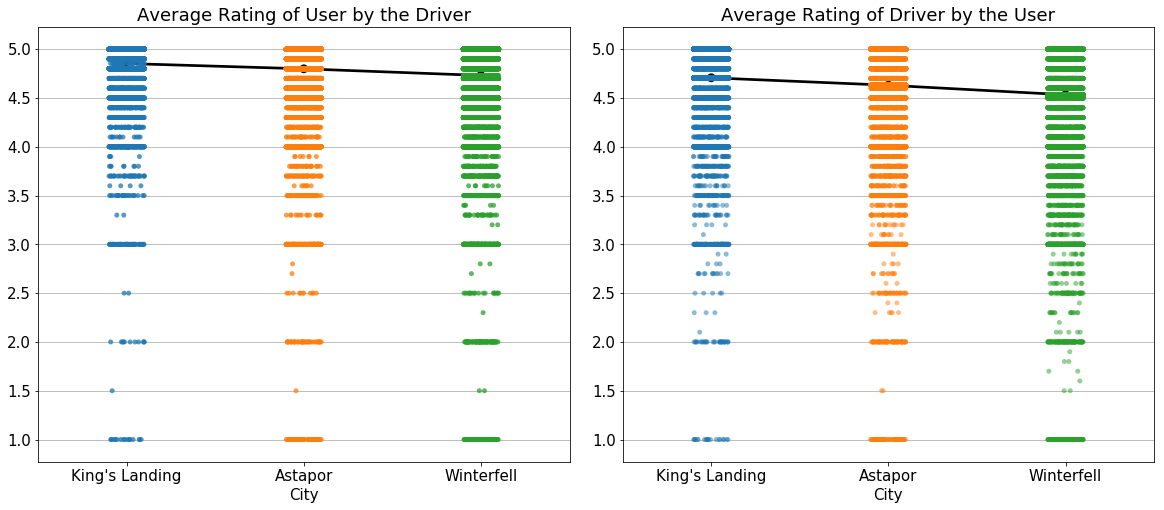

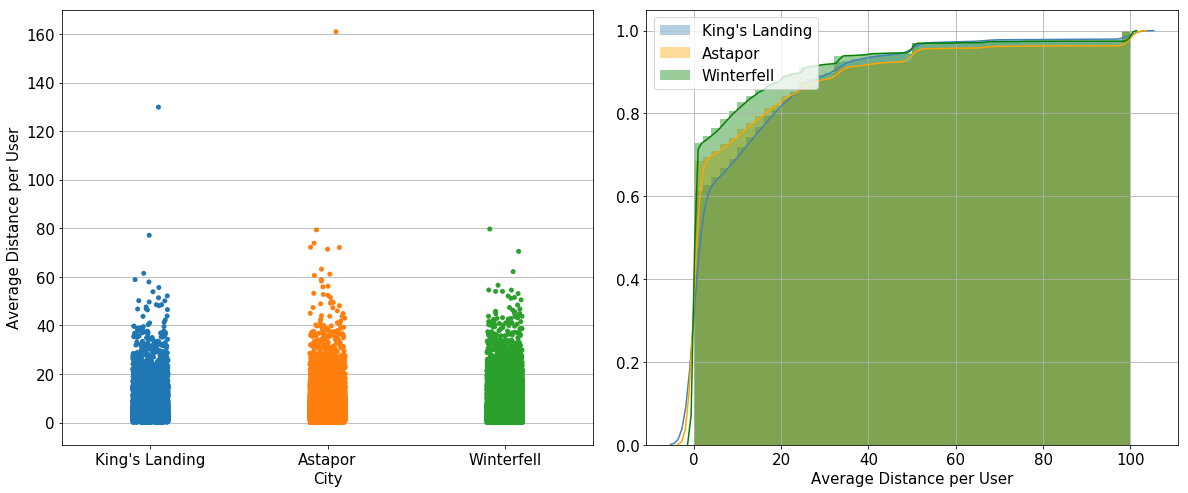

In [41]:
################################################################
fig,axes = plt.subplots(1,2,figsize=(20,8))
sns.catplot(x = 'city', y = 'avg_rating_by_driver', data = df,alpha = 0.75, ax=axes[0])
sns.catplot(x = 'city', y = 'avg_rating_by_driver', data = df,kind = 'point',color = 'k',ax=axes[0])
axes[0].set_title('Average Rating of User by the Driver')
axes[0].set_xlabel('City')
axes[0].set_ylabel('')
sns.catplot(x = 'city', y = 'avg_rating_of_driver', data = df,alpha = 0.5,ax=axes[1])
sns.catplot(x = 'city', y = 'avg_rating_of_driver', data = df,kind = 'point',color = 'k',ax=axes[1])
axes[1].set_title('Average Rating of Driver by the User')
axes[1].set_xlabel('City')
axes[1].set_ylabel('')
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.subplots_adjust(wspace=0.1)
plt.show()
################################################################
colors = ['steelblue','orange','green']
fig,axes = plt.subplots(1,2,figsize=(20,8))
sns.catplot(x = 'city', y = 'avg_dist', data = df, ax = axes[0], marker = 'o')
axes[0].set_xlabel('City')
axes[0].set_ylabel('Average Distance per User')
for i,name in enumerate(citynames):
    sns.distplot(df[df.city == name].surge_pct,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True), ax = axes[1], color = colors[i], label = name)
    axes[1].set_xlabel('Average Distance per User')
    axes[1].legend(loc = 'upper left')
plt.close(2)
plt.close(3)
plt.subplots_adjust(wspace=0.1)
plt.show()
################################################################

The average of average-ratings by and of the drivers was highest in the King's Landing and lowest in the Winterfell. The cumulative plot suggested that in King's Landing has the most number of smaller trip distances among the three cities.

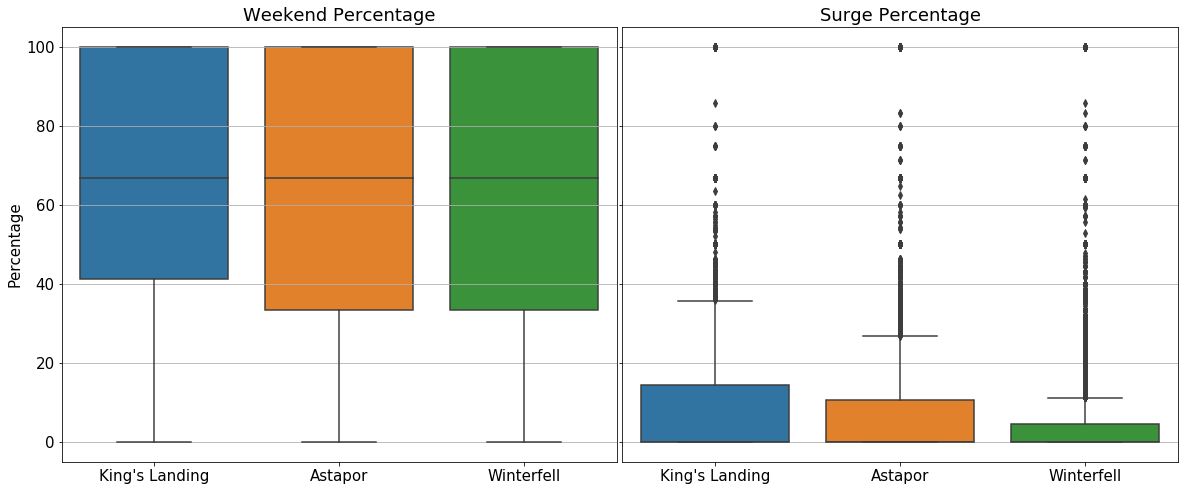

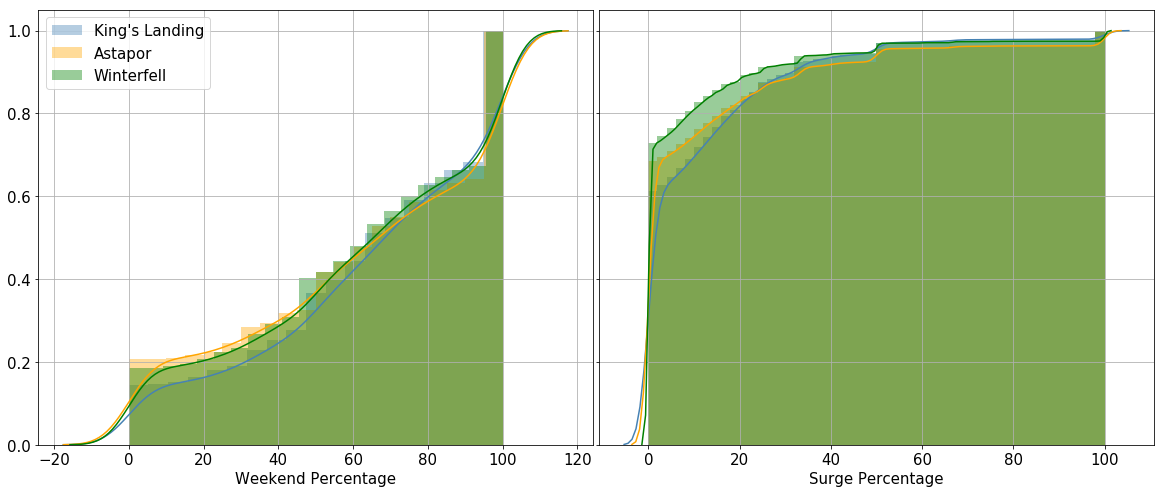

In [42]:
################################################################
fig,axes = plt.subplots(1,2,figsize=(20,8), sharey = True)
sns.boxplot(x = 'city', y = 'weekday_pct',data = df, ax = axes[0])
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('')
axes[0].set_title('Weekend Percentage')
sns.boxplot(x = 'city', y = 'surge_pct',data = df, ax = axes[1])
axes[1].set_xlabel('')
axes[1].set_title('Surge Percentage')
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0.01)
plt.show()
################################################################
colors = ['steelblue','orange','green']
fig,axes = plt.subplots(1,2,figsize=(20,8),sharey = True)
for i,name in enumerate(citynames):
    sns.distplot(df[df.city == name].weekday_pct,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True), ax = axes[0], color = colors[i], label = name)
    axes[0].set_xlabel('Weekend Percentage')
    axes[0].legend(loc = 'upper left')
for i,name in enumerate(citynames):
    sns.distplot(df[df.city == name].surge_pct,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True), ax = axes[1], color = colors[i])
    axes[1].set_xlabel('Surge Percentage')
plt.subplots_adjust(wspace=0.01)
plt.show()
################################################################

The weekend percentage of three cities was almost similar. On average, about 60% of users use the driving service. Majority of the users in winterfell, did not used the service as much as other two cities when the surge was > 1. However, the overall number was low and the company can explore improving this feature where the rides are used even when the surchage is high.

## Category - <span style="color:red">**PHONE** </span>

======================================== GROUP BY PHONE ========================================


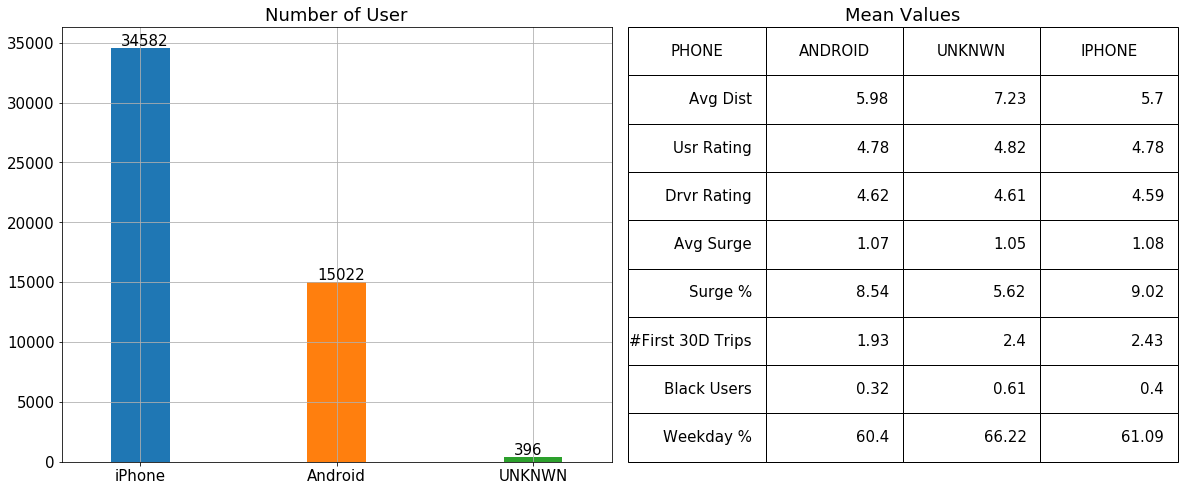

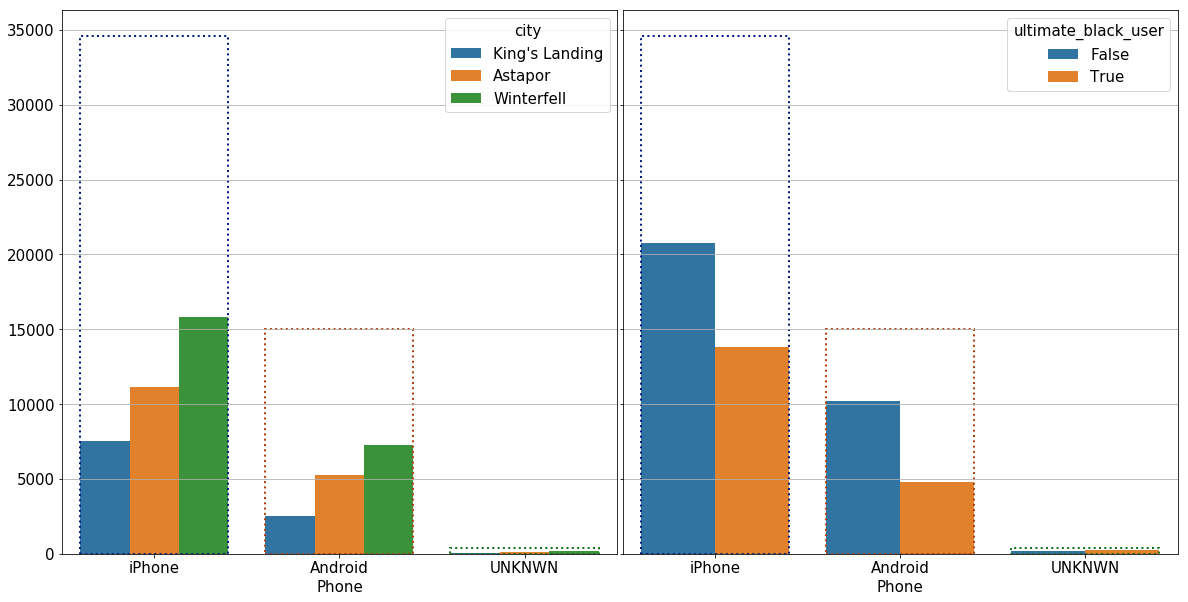

In [43]:
################################################################
################################################################
print('=='*50)
print('=='*20,'GROUP BY PHONE','=='*20)
print('=='*50)
phonenames = df.phone.unique()
cat_plots('phone')
################################################################
################################################################
fig,axes = plt.subplots(1,2,figsize=(20,10),sharey = True)

sns.countplot(x = 'phone', hue = 'city',data = df,linewidth=4, ax= axes[0])
sns.countplot(x = 'phone',data = df, ax= axes[0],
              facecolor=(0, 0, 0, 0),
              linewidth=2,
              linestyle = ':',
              edgecolor=sns.color_palette("dark", 3))
axes[0].set_ylabel('')
axes[0].set_xlabel('Phone')
sns.countplot(x = 'phone', hue = 'ultimate_black_user',data = df, ax= axes[1])
sns.countplot(x = 'phone',data = df, ax= axes[1],
              facecolor=(0, 0, 0, 0),
              linewidth=2,
              linestyle = ':',
              edgecolor=sns.color_palette("dark", 3))
axes[1].set_ylabel('')
axes[1].set_xlabel('Phone')
plt.subplots_adjust(wspace=0.01)
plt.show()
################################################################

In the phone categories there were relatively more variations amoung the different user categories. Number of users with iPhones were almost double of android. Most of the ultimate black users were without iphone or androids which higher average distance. Due to the service used, average rating of and by the drivers was higher for users without iPhone and androids. 

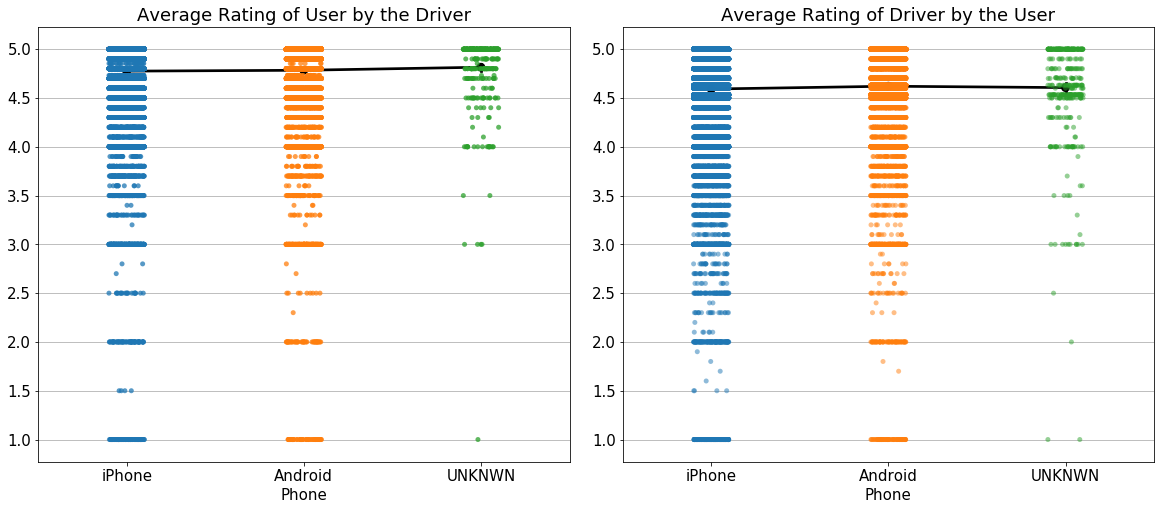

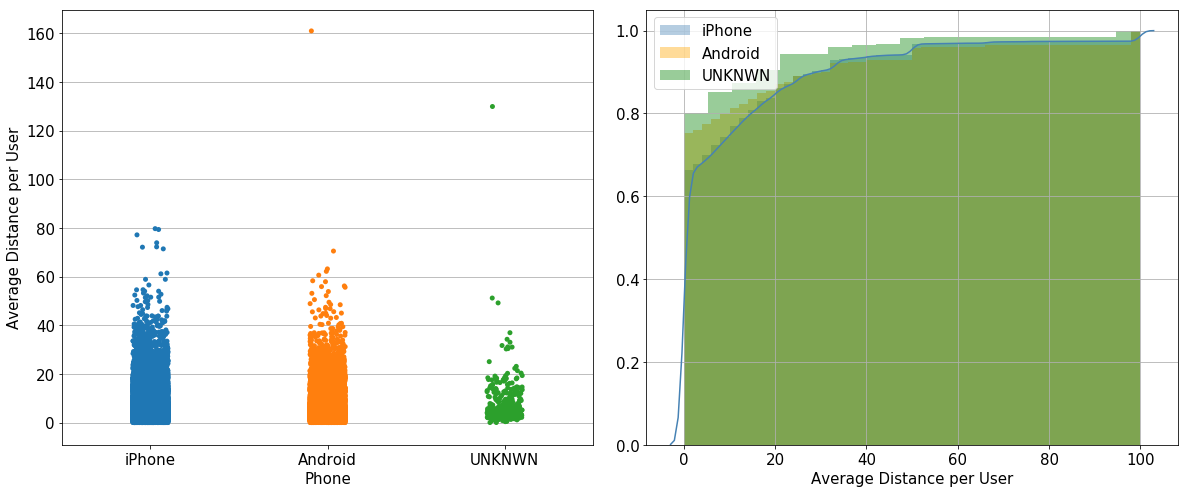

In [44]:
################################################################
fig,axes = plt.subplots(1,2,figsize=(20,8))
sns.catplot(x = 'phone', y = 'avg_rating_by_driver', data = df,alpha = 0.75, ax=axes[0])
sns.catplot(x = 'phone', y = 'avg_rating_by_driver', data = df,kind = 'point',color = 'k',ax=axes[0])
axes[0].set_title('Average Rating of User by the Driver')
axes[0].set_xlabel('Phone')
axes[0].set_ylabel('')
sns.catplot(x = 'phone', y = 'avg_rating_of_driver', data = df,alpha = 0.5,ax=axes[1])
sns.catplot(x = 'phone', y = 'avg_rating_of_driver', data = df,kind = 'point',color = 'k',ax=axes[1])
axes[1].set_title('Average Rating of Driver by the User')
axes[1].set_xlabel('Phone')
axes[1].set_ylabel('')
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.subplots_adjust(wspace=0.1)
plt.show()
################################################################
colors = ['steelblue','orange','green']
fig,axes = plt.subplots(1,2,figsize=(20,8))
sns.catplot(x = 'phone', y = 'avg_dist', data = df, ax = axes[0], marker = 'o')
axes[0].set_xlabel('Phone')
axes[0].set_ylabel('Average Distance per User')
for i,name in enumerate(phonenames):
    sns.distplot(df[df.phone == name].surge_pct,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True), ax = axes[1], color = colors[i], label = name)
    axes[1].set_xlabel('Average Distance per User')
    axes[1].legend(loc = 'upper left')
plt.close(2)
plt.close(3)
plt.subplots_adjust(wspace=0.1)
plt.show()
################################################################

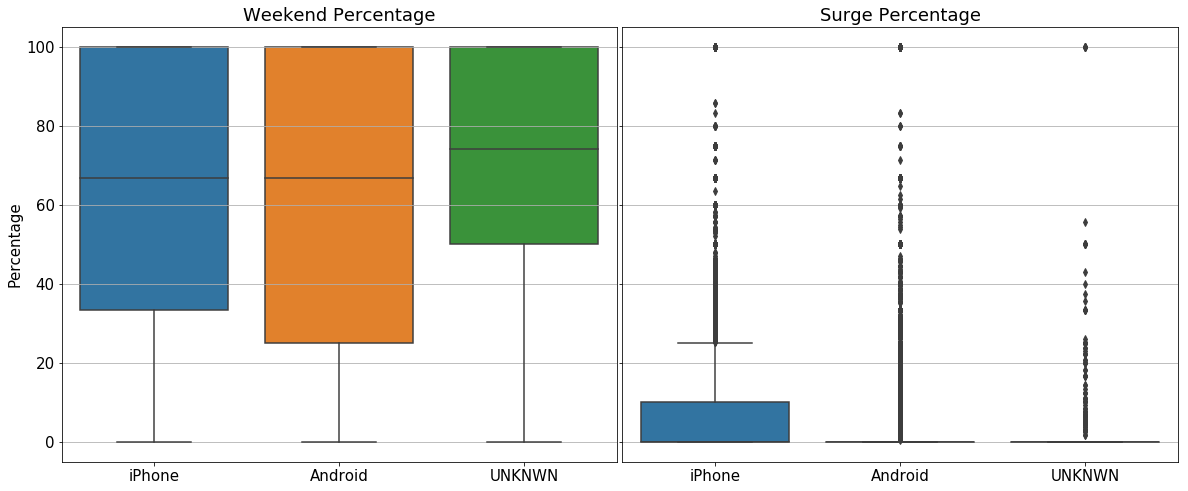

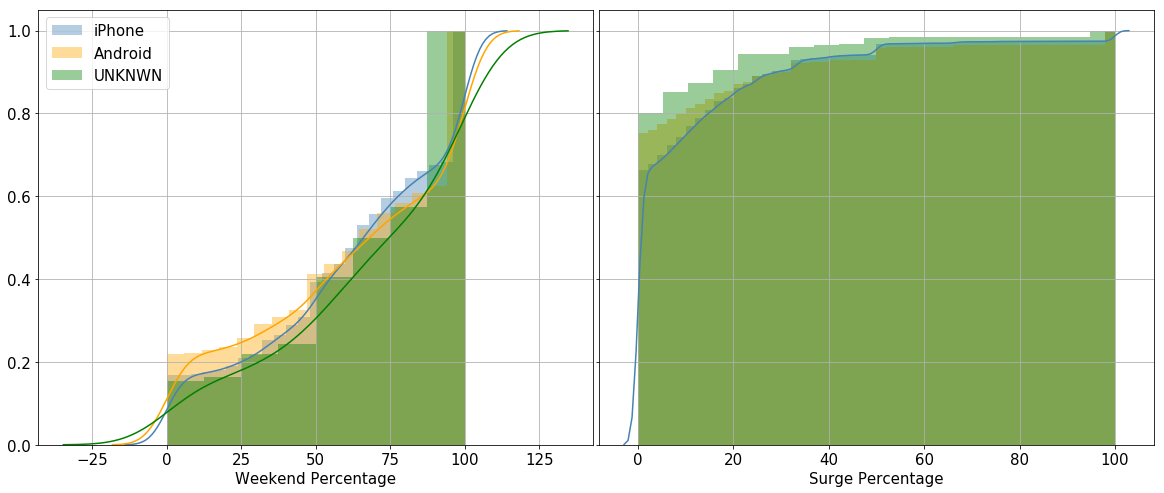

In [45]:
################################################################
fig,axes = plt.subplots(1,2,figsize=(20,8), sharey = True)
sns.boxplot(x = 'phone', y = 'weekday_pct',data = df, ax = axes[0])
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('')
axes[0].set_title('Weekend Percentage')
sns.boxplot(x = 'phone', y = 'surge_pct',data = df, ax = axes[1])
axes[1].set_xlabel('')
axes[1].set_title('Surge Percentage')
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0.01)
plt.show()
################################################################
colors = ['steelblue','orange','green']
fig,axes = plt.subplots(1,2,figsize=(20,8),sharey = True)

for i,name in enumerate(phonenames):
    sns.distplot(df[df.phone == name].weekday_pct,
                 hist_kws=dict(cumulative=True),
                 kde_kws=dict(cumulative=True),
                 ax = axes[0], color = colors[i], label = name)
    axes[0].set_xlabel('Weekend Percentage')
    axes[0].legend(loc = 'upper left')
    
    
    sns.distplot(df[df.phone == name].surge_pct,
                 hist_kws=dict(cumulative=True),
                 kde_kws=dict(cumulative=True),
                 ax = axes[1], color = colors[i])
    axes[1].set_xlabel('Surge Percentage')
    

plt.subplots_adjust(wspace=0.01)
plt.show()
################################################################

## Category - <span style="color:red">**ULTIMATE BLACK USER** </span>

======================================== GROUP BY ULTIMATE BLACK USER ========================================


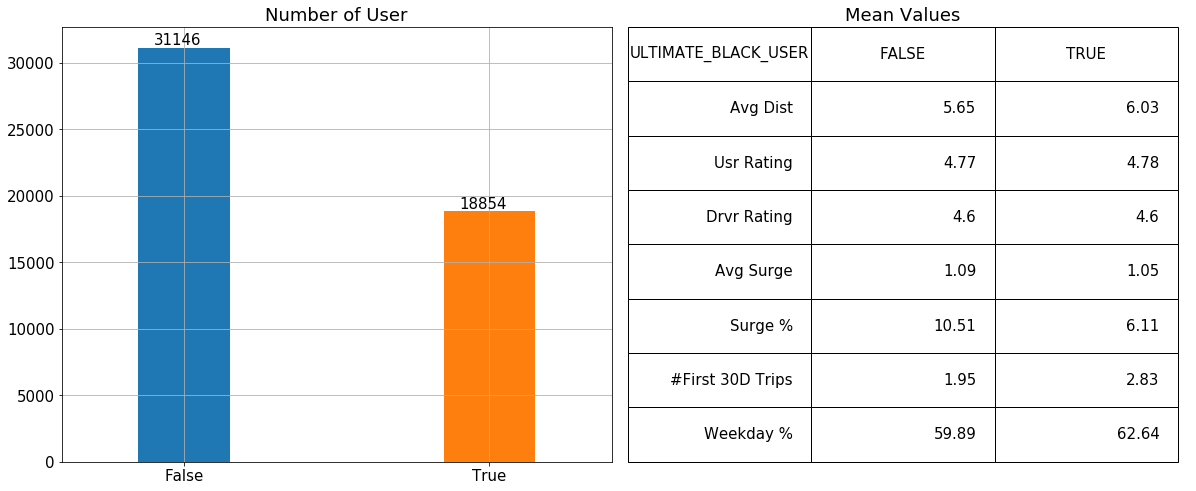

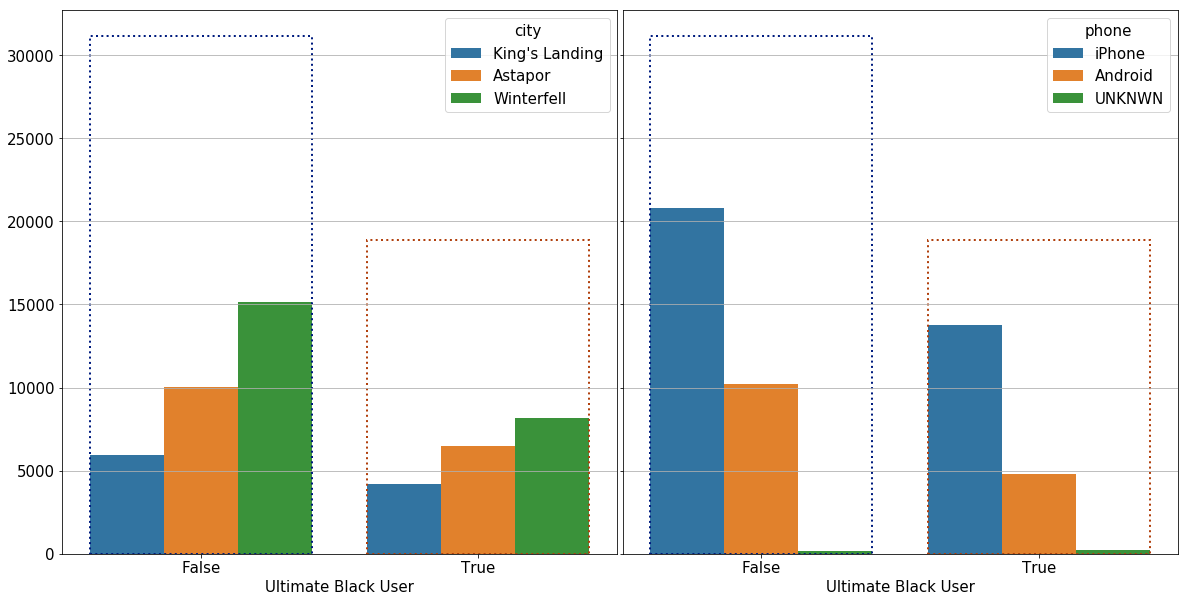

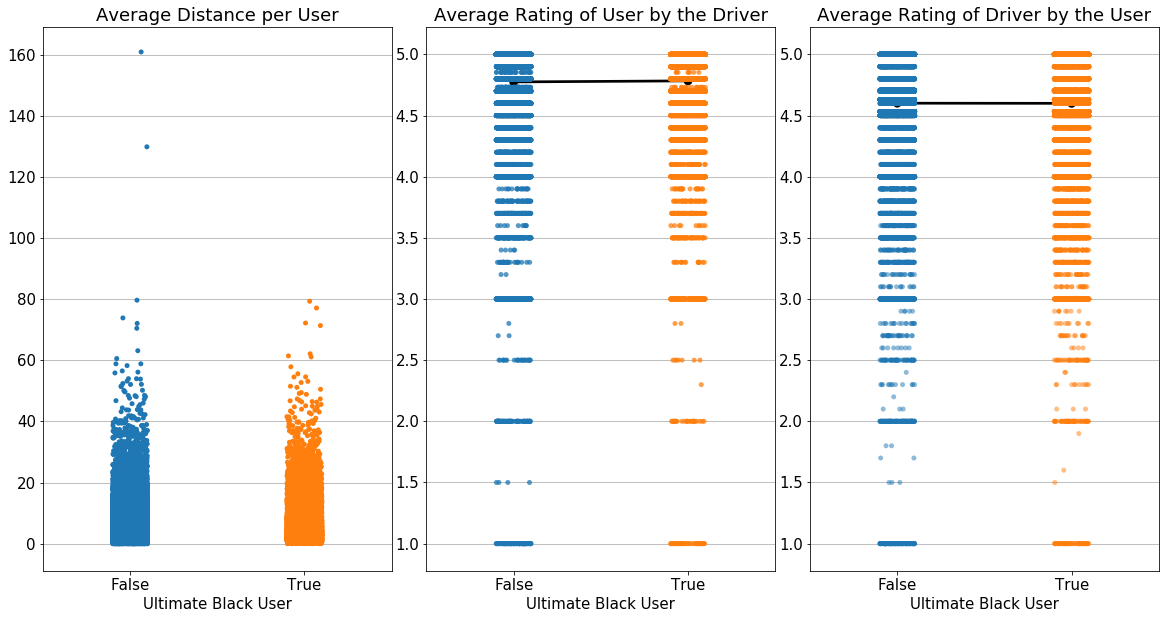

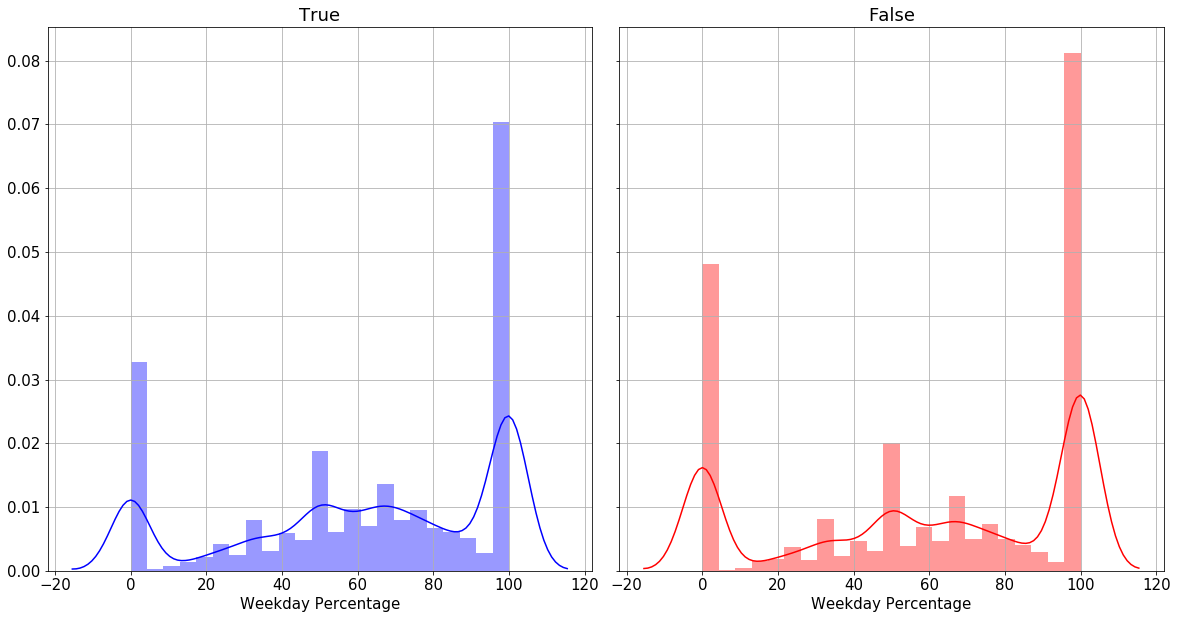

In [46]:
################################################################
################################################################
print('=='*50)
print('=='*20,'GROUP BY ULTIMATE BLACK USER','=='*20)
print('=='*50)
blackusername = df.ultimate_black_user.unique()
cat_plots('ultimate_black_user')
################################################################
################################################################
fig,axes = plt.subplots(1,2,figsize=(20,10),sharey = True)

sns.countplot(x = 'ultimate_black_user', hue = 'city',data = df,linewidth=4, ax= axes[0])
sns.countplot(x = 'ultimate_black_user',data = df, ax= axes[0],
              facecolor=(0, 0, 0, 0),
              linewidth=2,
              linestyle = ':',
              edgecolor=sns.color_palette("dark", 3))
axes[0].set_ylabel('')
axes[0].set_xlabel('Ultimate Black User')

sns.countplot(x = 'ultimate_black_user', hue = 'phone',data = df, ax= axes[1])
sns.countplot(x = 'ultimate_black_user',data = df, ax= axes[1],
              facecolor=(0, 0, 0, 0),
              linewidth=2,
              linestyle = ':',
              edgecolor=sns.color_palette("dark", 3))

axes[1].set_ylabel('')
axes[1].set_xlabel('Ultimate Black User')

plt.subplots_adjust(wspace=0.01)
plt.show()
################################################################
################################################################
fig,axes = plt.subplots(1,3,figsize=(20,10))

sns.catplot(x = 'ultimate_black_user', y = 'avg_dist', data = df, ax = axes[0], marker = 'o')
axes[0].set_xlabel('Ultimate Black User')
axes[0].set_title('Average Distance per User')
axes[0].set_ylabel('')

sns.catplot(x = 'ultimate_black_user', y = 'avg_rating_by_driver', data = df,alpha = 0.75, ax=axes[1])
sns.catplot(x = 'ultimate_black_user', y = 'avg_rating_by_driver', data = df,kind = 'point',color = 'k',ax=axes[1])
axes[1].set_title('Average Rating of User by the Driver')
axes[1].set_xlabel('Ultimate Black User')
axes[1].set_ylabel('')

sns.catplot(x = 'ultimate_black_user', y = 'avg_rating_of_driver', data = df,alpha = 0.5,ax=axes[2])
sns.catplot(x = 'ultimate_black_user', y = 'avg_rating_of_driver', data = df,kind = 'point',color = 'k',ax=axes[2])
axes[2].set_title('Average Rating of Driver by the User')
axes[2].set_xlabel('Ultimate Black User')
axes[2].set_ylabel('')

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.close(6)
plt.subplots_adjust(wspace=0.1)
plt.show()
################################################################
################################################################
colors = ['blue','red','green']
fig,axes = plt.subplots(1,2,figsize=(20,10),sharey = True)
for i,name in enumerate(blackusername):
    sns.distplot(df[df.ultimate_black_user == name].weekday_pct, ax = axes[i], color = colors[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Weekday Percentage')

plt.subplots_adjust(wspace=0.05)
plt.show()
################################################################
################################################################

Number of black service users were higher was higher in Winterfell compared to the King's Landing. 

In [47]:
df[['last_trip_date','signup_date']].describe()

,last_trip_date,signup_date
count,50000,50000
unique,182,31
top,2014-06-29,2014-01-18
freq,2036,2948


In [48]:
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date)

Based on the desciption signups were only recorded for month of January. For the last trip, first size months of data is available. As described in the problem statement, users active within the last 30 days were considered as retained. From the table above, we note that last date was July 1st, 2014. Thus all user in the month of June (excluding June 1st) were the retained users as shown in the figure below in green patch. Since we are interested in having a high retention rate, lets add a binary column into the dataframe indicating weather a user was retained or not.

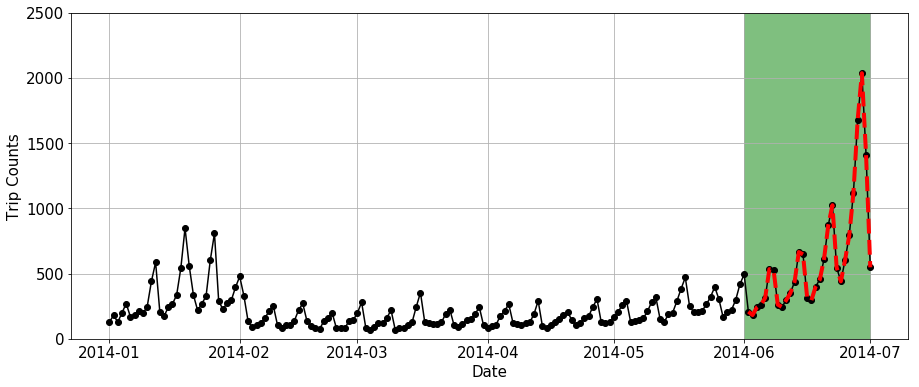

In [49]:
temp_df = pd.DataFrame(df.last_trip_date.value_counts()).sort_index()
fig,ax1 = plt.subplots(1,1)
ax1.plot(temp_df, 'ko-')
ax1.plot(temp_df['2014-06-02':], linewidth = 4,linestyle= '--', color = 'r')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trip Counts')
ax1.set_ylim([0,2500])
ax1.axvspan('2014-06-01', '2014-07-01', alpha=0.5, color='green');

In [50]:
df['user_retained'] = 1*(df.last_trip_date > '2014-06')
df['ultimate_black_user'] = 1*df['ultimate_black_user'] 

In [51]:
print('Retention Rate: {}%'.format(np.around(df.user_retained.sum()/len(df)*100),2))

Retention Rate: 37.0%


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
user_retained             50000 non-null int64
dtypes: datetime64[ns](2), float64(6), int64(3), object(2)
memory usage: 5.0+ MB


In [53]:
df1 = df.select_dtypes(include = ['object']).copy()

In [54]:
lb_style = LabelBinarizer()
lb_results1 = lb_style.fit_transform(df1.city)
df2 = pd.DataFrame(lb_results1, columns=lb_style.classes_)
lb_style = LabelBinarizer()
lb_results2 = lb_style.fit_transform(df1.phone)
df3 = pd.DataFrame(lb_results2, columns=lb_style.classes_)
df4 = df.select_dtypes(include = [np.number]).copy()
df6 = pd.concat([df2,df3,df4],axis = 1)
labels = df6['user_retained']
features = df6.drop('user_retained', axis = 1)
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
Astapor                   50000 non-null int64
King's Landing            50000 non-null int64
Winterfell                50000 non-null int64
Android                   50000 non-null int64
UNKNWN                    50000 non-null int64
iPhone                    50000 non-null int64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
user_retained             50000 non-null int64
dtypes: float64(6), int64(9)
memory usage: 5.7 MB


In [55]:

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33500, 14)
(16500, 14)
(33500,)
(16500,)


# Decision Tree Models

Random Forest and Gradient Boosting classifiers were used to train on the train and test the model performance on the test sets. The two models were trained using the 5 fold cross-validation on different hyperparameters.

In [56]:
from sklearn.metrics import classification_report, roc_auc_score,  accuracy_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

Note: The code in the next snippet is to run the grid search for random forest and gradient boosting methods.
The execution time for the code is slightly mode than an hour and thus has be hashed. But the code is correct and executable.

The hyper parameters used in the decision tree models below were obtained from this grid search best fits.

In [57]:
# param_grid_rf = {'max_depth': [30,50,60],
#                  'n_estimators': [300, 500, 800],
#                  'criterion':["gini",'entropy'],
#                  'max_features': [5,6,10],
#                  'min_samples_split': [8,10,12]}

# param_grid_gb = {'learning_rate': [0.1,0.01],
#                  'max_depth': [3,5,8],
#                  'n_estimators': [500,800],
#                  'min_samples_split': [5,8,10]}

# for clf, name in ((GradientBoostingClassifier(),'Gradient Boosting'),(RandomForestClassifier(), "Random Forest")):
#     print('=' * 80)
#     print(clf)
#     # Instantiate the grid search model
#     if name == 'Random Forest':
#         grid_result = GridSearchCV(estimator = clf, param_grid = param_grid_rf, cv = 5, verbose = 2)
#     else:
#         grid_result = GridSearchCV(estimator = clf, param_grid = param_grid_gb, cv = 5, verbose = 2)
    
#     grid_result.fit(X_train,Y_train)
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#     means = grid_result.cv_results_['mean_test_score']
#     stds = grid_result.cv_results_['std_test_score']
#     params = grid_result.cv_results_['params']
#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

#     # Calculate the accuracy and predictions
#     score = grid_result.score(X_test, Y_test)
#     print("Test score: {0:.2f} %".format(100 * score))
#     predict = grid_result.predict(X_test)

## Random Forest Classifier

________________________________________________________________________________
Training: RandomForestClassifier 
________________________________________________________________________________
train time: 10.064s
test time:  0.919s
Accuracy Score:   0.777
________________________________________________________________________________
classification report:
              precision    recall  f1-score   support

    Retained       0.81      0.85      0.83     10466
Not-Retained       0.71      0.66      0.68      6034

    accuracy                           0.78     16500
   macro avg       0.76      0.75      0.76     16500
weighted avg       0.77      0.78      0.78     16500

________________________________________________________________________________
confusion matrix:
[[8845 1621]
 [2055 3979]]
________________________________________________________________________________


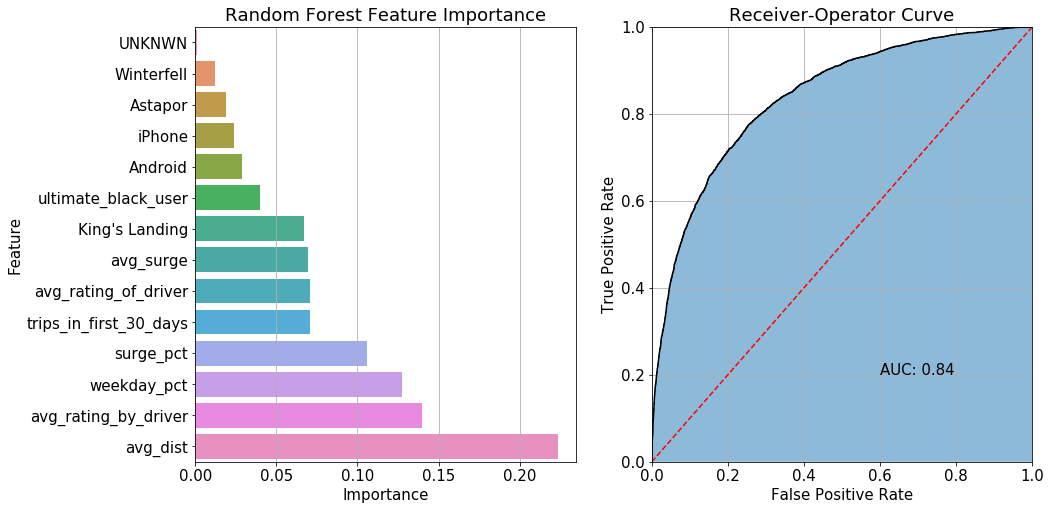

Accuracy = 77.72%, Area Under ROC Curve: 0.84


In [58]:
Results = []
rf = RandomForestClassifier(n_estimators=300, max_depth = 50,max_features=5,min_samples_split=8)
print('_' * 80)
print("Training: RandomForestClassifier ")
print('_' * 80)
t0 = time()
rf.fit(X_train, y_train)
train_time_rf = time() - t0
print("train time: %0.3fs" % train_time_rf)

t0 = time()
y_pred = rf.predict(X_test)
test_time_rf = time() - t0
print("test time:  %0.3fs" % test_time_rf)

score = accuracy_score(y_test,y_pred)
print("Accuracy Score:   %0.3f" % score)
print('_' * 80)
print("classification report:")
print(classification_report(y_test, y_pred,target_names=['Retained','Not-Retained']))
print('_' * 80)
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print('_' * 80)
# Compute predicted probabilities
y_pred_prob = rf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

feat_imp_rf = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp_rf['Feature'] = features.columns
feat_imp_rf.sort_values(by='Importance', ascending=True, inplace=True)
feat_imp_rf = feat_imp_rf.iloc[:14]

# Plot ROC curve
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,8))

sns.barplot(y="Feature", x="Importance", data=feat_imp_rf, ax = ax1)
ax1.set_title('Random Forest Feature Importance')

ax2.plot(fpr, tpr, 'k-')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.fill_between(fpr, tpr, alpha =0.5)
ax2.axis([0,1,0,1])

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver-Operator Curve')

roc_score = roc_auc_score(y_test, y_pred_prob)
ax2.text(0.6,0.2,'AUC: {}'.format(np.round(roc_score,2)));

plt.show()


print('=' * 80)
print('Accuracy = {}%, Area Under ROC Curve: {}'.format(np.round(score*100,2), np.round(roc_score,2)))
print('=' * 80)

Results.append(('Random Forest Classifier', score, train_time_rf, test_time_rf,np.round(roc_score,2)))

## Gradient Boosting Model

________________________________________________________________________________
Training: Gradient Boosting Classifier 
________________________________________________________________________________
train time: 8.452s
test time:  0.087s
Accuracy Score:   0.794
________________________________________________________________________________
classification report:
              precision    recall  f1-score   support

    Retained       0.82      0.87      0.84     10466
Not-Retained       0.74      0.67      0.70      6034

    accuracy                           0.79     16500
   macro avg       0.78      0.77      0.77     16500
weighted avg       0.79      0.79      0.79     16500

________________________________________________________________________________
confusion matrix:
[[9056 1410]
 [1996 4038]]
________________________________________________________________________________


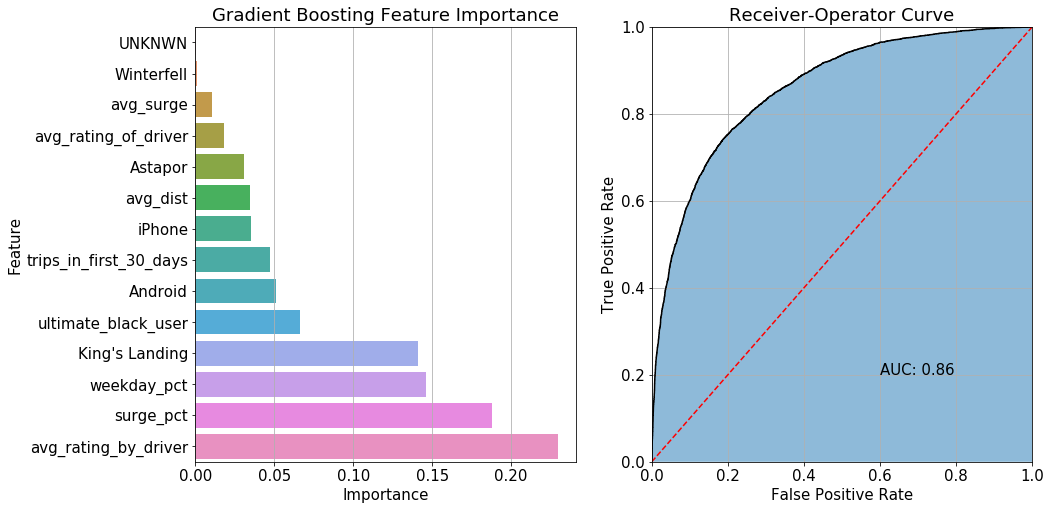

Accuracy = 79.36%, Area Under ROC Curve: 0.86


In [59]:
gb = GradientBoostingClassifier(n_estimators=500, max_depth = 3,min_samples_split=10,learning_rate=0.1)
print('_' * 80)
print("Training: Gradient Boosting Classifier ")
print('_' * 80)
t0 = time()
gb.fit(X_train, y_train)
train_time_gb = time() - t0
print("train time: %0.3fs" % train_time_gb)

t0 = time()
y_pred = gb.predict(X_test)
test_time_gb = time() - t0
print("test time:  %0.3fs" % test_time_gb)

score = accuracy_score(y_test,y_pred)
print("Accuracy Score:   %0.3f" % score)
print('_' * 80)
print("classification report:")
print(classification_report(y_test, y_pred,target_names=['Retained','Not-Retained']))
print('_' * 80)
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print('_' * 80)
# Compute predicted probabilities
y_pred_prob = gb.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

feat_imp_gb = pd.DataFrame({'Importance':gb.feature_importances_})    
feat_imp_gb['Feature'] = features.columns
feat_imp_gb.sort_values(by='Importance', ascending=True, inplace=True)
feat_imp_gb = feat_imp_gb.iloc[:14]

# Plot ROC curve
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,8))

sns.barplot(y="Feature", x="Importance", data=feat_imp_gb, ax = ax1)
ax1.set_title('Gradient Boosting Feature Importance')

ax2.plot(fpr, tpr, 'k-')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.fill_between(fpr, tpr, alpha =0.5)
ax2.axis([0,1,0,1])

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver-Operator Curve')

roc_score = roc_auc_score(y_test, y_pred_prob)
ax2.text(0.6,0.2,'AUC: {}'.format(np.round(roc_score,2)));

plt.show()


print('=' * 80)
print('Accuracy = {}%, Area Under ROC Curve: {}'.format(np.round(score*100,2), np.round(roc_score,2)))
print('=' * 80)

Results.append(('Gradient Boosting Classifier', score, train_time_gb, test_time_gb,np.round(roc_score,2)))

## Neural Network Classfier

In [60]:

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras.layers.core import Dropout
from keras import regularizers

Using TensorFlow backend.


In [61]:
# Standarize the date to be between 0, 1
sc = StandardScaler()
X = sc.fit_transform(features)

print('Shape of Input fetures: {} x {}'. format(X.shape[0],X.shape[1]))
      
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

Shape of Input fetures: 50000 x 14


________________________________________________________________________________
Training: Neural Network Classifier 
________________________________________________________________________________
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
train time: 5.362s
<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x1c44476eb8>>
test time:  0.135s
Accuracy Score:   0.773
________________________________________________________________________________
classification report:
              precision    recall  f1-score   support

    Retained       0.81      0.83      0.82      9384
Not-Retained       0.71      0.67      0.69      5616

    accuracy                           0.77     15000
   macro avg       0.76      0.75      0.76     15000
weighted avg       0.77      0.77      0.77     15000

confusion matrix:
[[7833 1551]
 [1851 3765]]


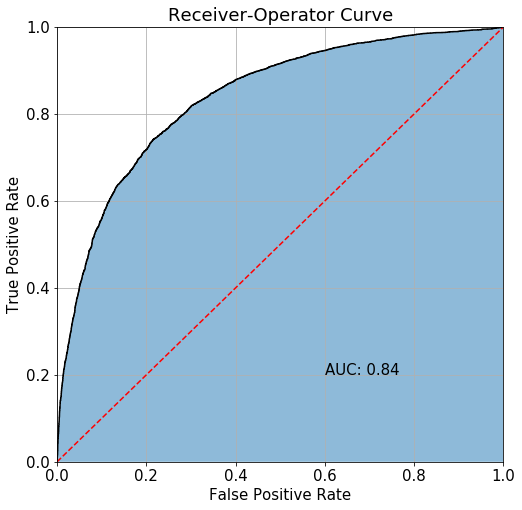

Accuracy = 77.32%, Area Under ROC Curve: 0.84


In [62]:
print('_' * 80)
print("Training: Neural Network Classifier ")
print('_' * 80)
model = Sequential()
#First Hidden Layer =
model.add(Dense(64, activation='relu', input_dim=14))
model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(8, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(4, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
#Output Layer
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

es = EarlyStopping(monitor='val_loss',patience=4)
t0 = time()
history = model.fit(X_train,y_train,epochs=20,batch_size=128,
                validation_data=(X_val, y_val),
                callbacks=[es], verbose = 0)
train_time = time() - t0
print("train time: %0.3fs" % train_time)
print(model.summary)

t0 = time()
y_pred=model.predict(X_test)
y_pred =(y_pred>0.5)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)
score = accuracy_score(y_test,y_pred)
print("Accuracy Score:   %0.3f" % score)
print('_' * 80)
print("classification report:")
print(classification_report(y_test, y_pred,target_names=['Retained','Not-Retained']))

print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))

y_pred_prob = model.predict_proba(X_test)
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
fig,(ax1) = plt.subplots(1,1,figsize=(8,8))

ax1.plot(fpr, tpr, 'k-')
ax1.plot([0, 1], [0, 1], 'r--')
ax1.fill_between(fpr, tpr, alpha =0.5)
ax1.axis([0,1,0,1])

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver-Operator Curve')

roc_score = roc_auc_score(y_test, y_pred_prob)
ax1.text(0.6,0.2,'AUC: {}'.format(np.round(roc_score,2)));

plt.show()

print('=' * 80)
print('Accuracy = {}%, Area Under ROC Curve: {}'.format(np.round(score*100,2), np.round(roc_score,2)))
print('=' * 80)

Results.append(('Neural Network Classifier', score, train_time, test_time,np.round(roc_score,2) ))

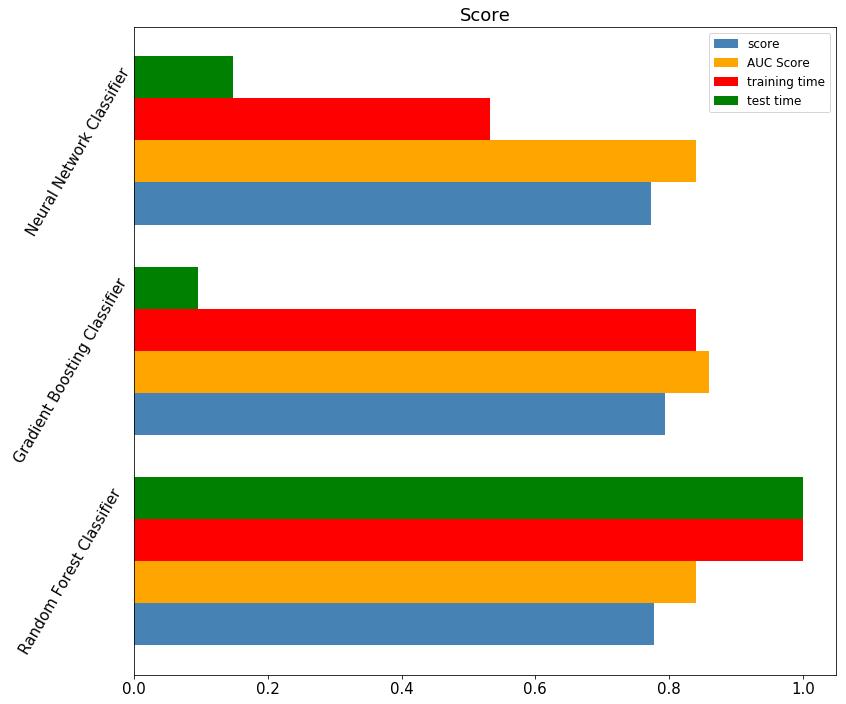

,Score,Training Time,Test Time,AUC Score
Classifier,,,,
Random Forest Classifier,0.777212,10.064102,0.918571,0.84
Gradient Boosting Classifier,0.793576,8.452317,0.087361,0.86
Neural Network Classifier,0.773200,5.362493,0.135204,0.84


In [63]:
indices = np.arange(len(Results))

results = [[x[i] for x in Results] for i in range(5)]

clf_names, score, training_time, test_time, AUC = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(15, 10))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='steelblue')
plt.barh(indices + .2, AUC, .2, label="AUC Score", color='orange')
plt.barh(indices + .4, training_time, .2, label="training time",color='r')
plt.barh(indices + .6, test_time, .2, label="test time", color='green')

plt.yticks(())

plt.legend(loc='best', fontsize = '12')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

clf_names = ['    Random Forest Classifier',
             '  Gradient Boosting Classifier',
            '       Neural Network Classifier']
for i, c in zip(indices, clf_names):
    plt.text(-.19, i+0.6, c, rotation = 60)
plt.grid()
plt.show()

Final_df = pd.DataFrame(Results)
Final_df.columns = ['Classifier','Score','Training Time', 'Test Time','AUC Score']
Final_df.set_index('Classifier',inplace = True)
Final_df

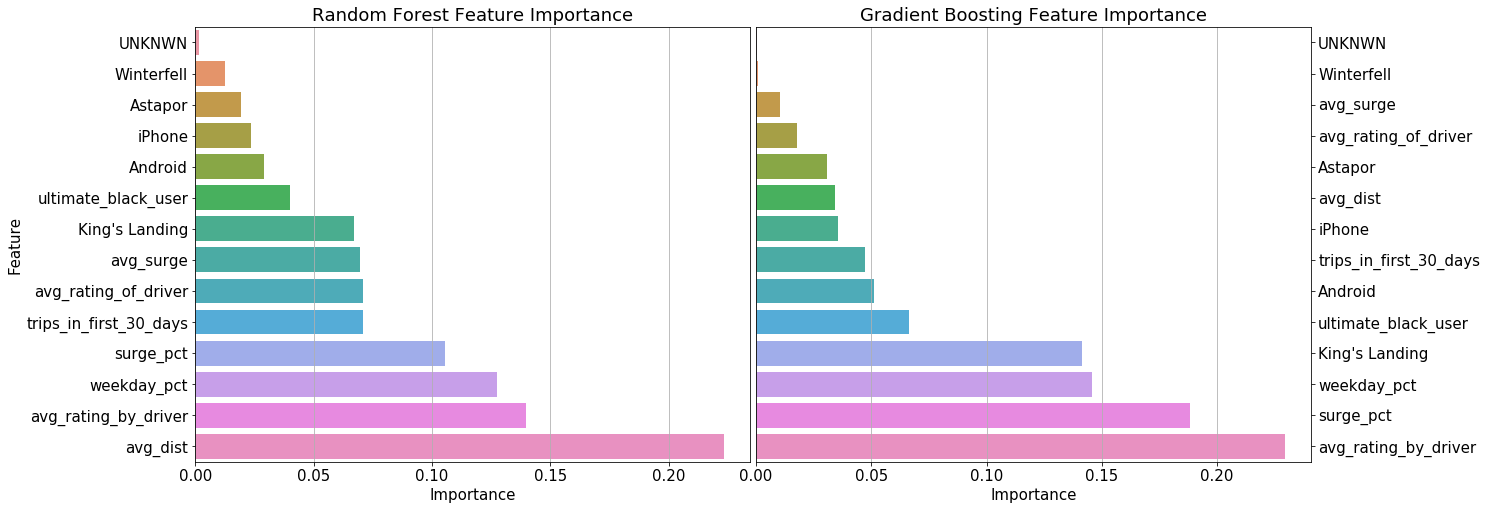

In [64]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

sns.barplot(y="Feature", x="Importance", data=feat_imp_rf, ax = ax1)
ax1.set_title('Random Forest Feature Importance')

ax2.yaxis.tick_right()
sns.barplot(y="Feature", x="Importance", data=feat_imp_gb, ax = ax2)
ax2.set_title('Gradient Boosting Feature Importance')
ax2.set_ylabel('')
plt.subplots_adjust(wspace=0.01)
plt.show()

Gradient Boosting Classifier had best performance among the three model with *accuracy score* of **79.2%** and *area-under-the-curve* was **0.85**.

Random Forest and Neural Network Classifiers had almost same performance. 

Both methods highlighted **'avg_rating_by_driver', 'surge_pct'** and **'Weekday_pct'** as most important features for classfiers. 

Random Forests also recommended **avg_dist** as the most most important feature for classification.

# Summary and Suggestions

Based on the performance of classifiers on the feature space following recommendations were suggested for *Ultimate*:

1. Improving on the experince of the drivers participating in the program. Thus focus should be on providing better service to both the users and the drivers.

2. Attract the customers to use the service during the surge hours. This would include either lowering the amoount of surcharge or providing incentives so that more users use the service in busy time zones.

3. Try building a more loyal customer base to increase the percent of trips users take during a weekday.

4. Last but not the list is to attract the user who are looking for longer trips. 
